In [1]:
%matplotlib inline

import cv2
import numpy as np
import pydicom as pyd
from os.path import join
from IPython import display
from matplotlib import  pyplot as plt

In [2]:
DIR = '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067'
name_template = '011207915T067_08%d.dcm'

In [5]:
data = pyd.dcmread(join(DIR, '011145698T100_091.dcm'))

In [17]:
img = data.pixel_array.astype(np.int16)
print ('img shape %s data type %s' % (img.shape, img.dtype))

img shape (512, 512) data type int16


In [18]:
intercept = data.RescaleIntercept
slope = data.RescaleSlope

print ('CT data intercept %s slope %s' %(intercept, slope))

CT data intercept 0 slope 1


In [32]:
img = img.astype(np.float64) * slope + intercept
print ('img shape %s data type %s' % (img.shape, img.dtype))

img shape (512, 512) data type float64


In [33]:
window_center = -600
window_width = 1500

In [36]:
lungwin = np.array([window_center - window_width // 2., window_center + window_width // 2])
lungwin

array([-1350.,   150.])

In [37]:
adjusted_img = (img - lungwin[0]) / (lungwin[1] - lungwin[0])

In [40]:
print('img value range [%2f, %2f]' % (adjusted_img.max(), adjusted_img.min()))

img value range [1.930000, -0.465333]


In [41]:
adjusted_img[adjusted_img < 0 ] = 0
adjusted_img[adjusted_img > 1] = 1
adjusted_img = (adjusted_img * 255).astype(np.uint8)

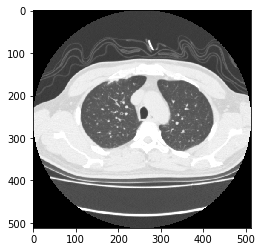

In [43]:
plt.imshow(adjusted_img, cmap=plt.cm.gray)

In [46]:
len(adjusted_img.shape)

2

In [15]:
def load_scan(slice_files, raise_512=False):
    window_center = -600
    window_width = 1500
    slices = []
    accept = False
    for s in slice_files:
        slices.append(pyd.read_file(s, force=True))
        if (not accept) and raise_512 and slices[-1].pixel_array.shape[0] != 512:
            print('find 512 scale dicom')
            raise NotImplemented
        accept = True
    img = np.stack([s.pixel_array for s in slices]).astype(np.int16)
    # image = image.astype(np.int16)
    # print 'CT Hu range: ' + str(image.min()) + '--' + str(image.max())

    # Convert to Hounsfield units (HU)
    # intercept = slices[0].RescaleIntercept
    # slope = slices[0].RescaleSlope
    intercept = np.stack([s.RescaleIntercept for s in slices])
    slope = np.stack([s.RescaleSlope for s in slices])
    # if slope != 1:
    img = img.astype(np.float64) * slope[:, np.newaxis, np.newaxis]
    img = img.astype(np.int16)
    img += np.int16(intercept[:, np.newaxis, np.newaxis])
    lungwin = np.array([window_center - window_width // 2., window_center + window_width // 2])
    newimg = (img - lungwin[0]) / (lungwin[1] - lungwin[0])
    newimg[newimg < 0] = 0
    newimg[newimg > 1] = 1
    newimg = (newimg * 255).astype('uint8')

    equalize_hist(newimg)

    return newimg

def equalize_hist(img):
    assert len(img.shape) == 3, 'except image dimension: 3, got {}'.format(len(img.shape))
    clhe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    for idx, c in enumerate(img):
        img[idx] = clhe.apply(c)

In [25]:
files = [ join(DIR, '011207915T067_0%d.dcm'%i) for i in range(80, 100)]

In [26]:
imgs = load_scan(files)

In [27]:
imgs.shape

(20, 512, 512)

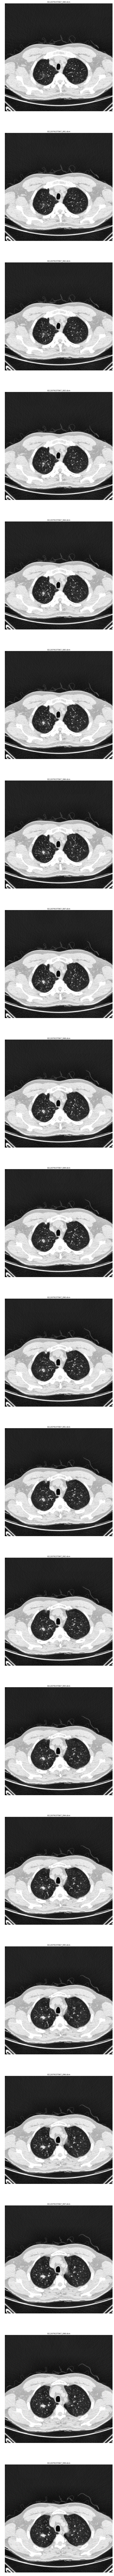

In [28]:
plt.figure(figsize=(16,16*20))
for idx in range(1, 21):
    plt.subplot(20,1,idx)
    plt.title('011207915T067_0%d.dcm'%(79 + idx))
    plt.imshow(imgs[idx-1], cmap=plt.cm.gray)
    plt.axis('off')

['/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_080.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_081.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_082.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_083.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_084.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_085.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_086.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_087.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_088.dcm',
 '/media/tx-deepocean/Data/dataset/test2018/dcm/011207915T067/011207915T067_089.dcm']